In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision as mp
import os
from skimage import io
from sklearn.model_selection import train_test_split
import tensorflow as tf
import visualkeras

SEED = 42
TEST_PROP = 0.25
IMAGE_SHAPE = (227, 227)
BASE_PATH = "hirise-map-proj-v3_2/"
IMAGES_PATH = BASE_PATH + "map-proj-v3_2/"
BATCH_SIZE = 32
RANDOM_STATE = 42

mp.set_global_policy('mixed_float16')

2023-07-27 14:52:49.927910: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 14:52:50.645908: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1070, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


2023-07-27 14:52:51.458208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-27 14:52:51.516095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-27 14:52:51.516406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
devices = tf.config.list_physical_devices('GPU')
if len(devices) == 0: print("Please install the latest TensorFlow GPU release.")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!nvidia-smi

Thu Jul 27 14:52:51 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1070        Off | 00000000:01:00.0  On |                  N/A |
| 15%   52C    P2              32W / 185W |    838MiB /  8192MiB |     15%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Dataset creation

In [4]:
labels_df = pd.read_csv(BASE_PATH + "labels-map-proj_v3_2_train_val_test.csv", sep=" ")
labels_df['class'] = labels_df['class'].astype('string')
labels_df

,name,class,split
0,ESP_013049_0950_RED-0067.jpg,7,train
1,ESP_013049_0950_RED-0067-fv.jpg,7,train
2,ESP_013049_0950_RED-0067-brt.jpg,7,train
3,ESP_013049_0950_RED-0067-r90.jpg,7,train
4,ESP_013049_0950_RED-0067-r180.jpg,7,train
...,...,...,...
67805,ESP_018707_2205_RED-0041.jpg,0,test
67806,ESP_018707_2205_RED-0062.jpg,0,test
67807,ESP_018707_2205_RED-0105.jpg,0,test
67808,ESP_018707_2205_RED-0058.jpg,0,test


In [5]:
labels_df_nbrt = labels_df[~labels_df['name'].str.contains("brt")]
#labels_df = labels_df_nbrt
labels_df_nbrt

,name,class,split
0,ESP_013049_0950_RED-0067.jpg,7,train
1,ESP_013049_0950_RED-0067-fv.jpg,7,train
3,ESP_013049_0950_RED-0067-r90.jpg,7,train
4,ESP_013049_0950_RED-0067-r180.jpg,7,train
5,ESP_013049_0950_RED-0067-r270.jpg,7,train
...,...,...,...
67805,ESP_018707_2205_RED-0041.jpg,0,test
67806,ESP_018707_2205_RED-0062.jpg,0,test
67807,ESP_018707_2205_RED-0105.jpg,0,test
67808,ESP_018707_2205_RED-0058.jpg,0,test


In [20]:
train_df

,name,class,split
0,ESP_013049_0950_RED-0067.jpg,7,train
1,ESP_013049_0950_RED-0067-fv.jpg,7,train
2,ESP_013049_0950_RED-0067-brt.jpg,7,train
3,ESP_013049_0950_RED-0067-r90.jpg,7,train
4,ESP_013049_0950_RED-0067-r180.jpg,7,train
...,...,...,...
51053,ESP_011623_2100_RED-0414-r180.jpg,0,train
51054,ESP_011623_2100_RED-0414-r270.jpg,0,train
51055,ESP_011623_2100_RED-0414-fh.jpg,0,train
51056,ESP_011623_2100_RED-0414-fv.jpg,0,train


In [21]:
train_df = labels_df[labels_df['split'] == 'train']
val_df = labels_df[labels_df['split'] == 'val']
test_df = labels_df[labels_df['split'] == 'test']

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_PATH,
    x_col="name",
    y_col="class",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=RANDOM_STATE,
    has_ext=True,
    shuffle=True,
    color_mode="grayscale",
    stratify=True
)


val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGES_PATH,
    x_col="name",
    y_col="class",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=RANDOM_STATE,
    has_ext=True,
    color_mode="grayscale",
)

Found 51058 validated image filenames belonging to 8 classes.
Found 14959 validated image filenames belonging to 8 classes.


In [22]:
class_map = pd.read_csv(BASE_PATH + "classmap.csv", header=None, index_col=0) \
            .squeeze("columns") \
            .to_dict()
class_map

{0: 'other',
 1: 'crater',
 2: 'dark dune',
 3: 'slope streak',
 4: 'bright dune',
 5: 'impact ejecta',
 6: 'swiss cheese',
 7: 'spider'}

## Preliminary EDA

<Axes: xlabel='class', ylabel='count'>

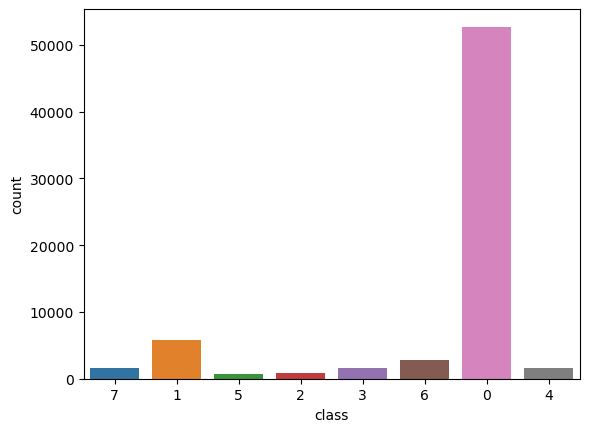

In [23]:
sns.countplot(x=labels_df['class'])

Most of the images are in the "other" category and the "crater" category.

In [24]:
labels_df['class'].value_counts()

0    52722
1     5857
6     2772
4     1654
3     1603
7     1568
2      857
5      777
Name: class, dtype: Int64

In [25]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67810 entries, 0 to 67809
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    67810 non-null  object
 1   class   67810 non-null  string
 2   split   67810 non-null  object
dtypes: object(2), string(1)
memory usage: 1.6+ MB


## Model building

In [37]:
model = keras.Sequential([
    layers.Conv2D(30, kernel_size=(3,3), activation='relu', input_shape=(227,227,1)),
    layers.Conv2D(30, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(2,2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.50),
    
    layers.Dense(len(class_map), activation='softmax'),
])

optimizer = keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

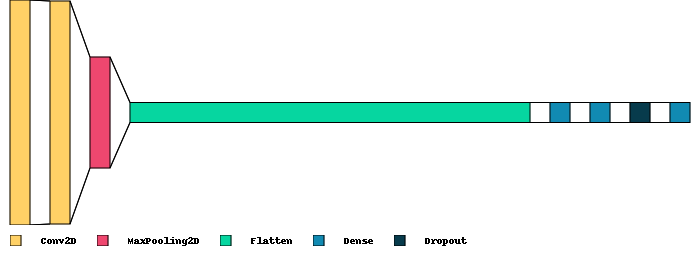

In [38]:
visualkeras.layered_view(model, scale_xy=1,legend=True, draw_volume=False, spacing=20)

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=8)

Epoch 1/8
2522/3192 [======================>.......] - ETA: 27s - loss: 0.8749 - accuracy: 0.7851

<Axes: >

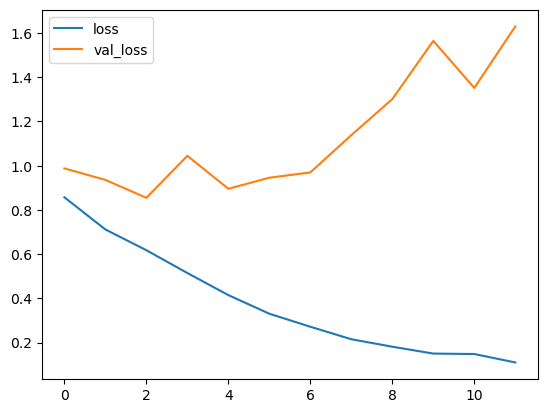

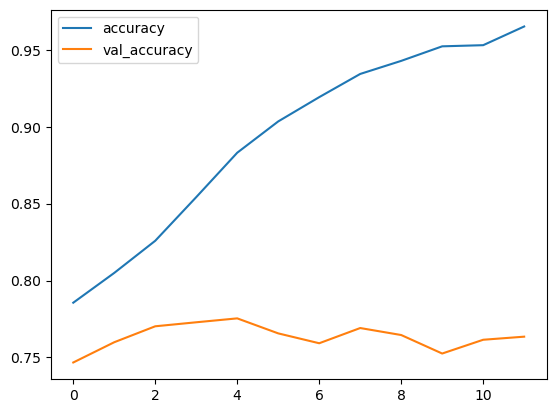

In [35]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

In [36]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=IMAGES_PATH,
    x_col="name",
    y_col="class",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=RANDOM_STATE,
    has_ext=True,
    shuffle=True,
    color_mode="grayscale",
    stratify=True
)

loss, accuracy = model.evaluate(test_gen, batch_size=BATCH_SIZE)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Found 1793 validated image filenames belonging to 8 classes.
113/113 [==============================] - 1s 10ms/step - loss: 1.2854 - accuracy: 0.8243
Loss:  1.2853553295135498
Accuracy:  0.8243167996406555


In [31]:
model.save("./mars_classifier.keras")